In [103]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [104]:
dataset_path = "Data/dog_images_resnet"

from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_with_aug = ImageDataGenerator(rotation_range=20,
            rescale = 1.0/255.0, # Normalize
            width_shift_range=0.2, # Simulating the effect of the object being in different positions
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=False,
            zoom_range=0.2, # simulate the object being at different distances
            shear_range=0.2, # simulating a tilting effect
            brightness_range=[0.8, 1.2], # under different lighting conditions
            fill_mode='nearest',
            validation_split = 0.4) # how to fill in newly created pixels

train_generator = data_with_aug.flow_from_directory(
    dataset_path,
    class_mode="categorical",
    target_size=(96, 96),
    batch_size=16,
    shuffle=True,
    subset="training"
)

validation_generator = data_with_aug.flow_from_directory(
    dataset_path,
    class_mode="categorical",
    target_size=(96, 96),
    batch_size=16,
    subset="validation"
)


Found 343 images belonging to 4 classes.
Found 226 images belonging to 4 classes.


# MobileNetV2

In [105]:
from tensorflow.keras.regularizers import l2
# Load the MobileNetV2 model with pretrained weights from ImageNet, excluding the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x=Dropout(0.1)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes for the 4 dog emotions

# Define learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',  
    patience=10,
    restore_best_weights=True
)

# Reasons for Choosing ReduceLROnPlateau

## Dynamic Learning Rate Adjustment:

ReduceLROnPlateau dynamically adjusts the learning rate during training based on the validation loss. If the validation loss stops improving for a certain number of epochs (patience), it reduces the learning rate by a factor (factor). This adaptability can be helpful in fine-tuning the model as it progresses through training.

## Stability in Convergence:

By reducing the learning rate when the validation loss stagnates, ReduceLROnPlateau can help stabilize the training process and prevent the model from overshooting or oscillating around the optimal solution.

# Example Use Case

## Fine-Tuning: 
As the model learns the features of different dog emotions, it may encounter plateaus in the training progress. ReduceLROnPlateau can adjust the learning rate accordingly, allowing the model to navigate through these plateaus more effectively.

## Preventing Overfitting: 
Dynamically reducing the learning rate based on the validation loss can help prevent overfitting, ensuring that the model generalizes well to unseen data and accurately predicts emotions in real-world scenarios.

In [106]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [107]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks = [reduce_lr, early_stop]
)


Epoch 1/30


/Users/oliverzhou/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.3272 - loss: 12.3678 - val_accuracy: 0.2876 - val_loss: 11.8347 - learning_rate: 0.0010
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4605 - loss: 11.2999 - val_accuracy: 0.2876 - val_loss: 11.5335 - learning_rate: 0.0010
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5931 - loss: 10.4555 - val_accuracy: 0.3053 - val_loss: 10.8053 - learning_rate: 0.0010
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6521 - loss: 9.8286 - val_accuracy: 0.3142 - val_loss: 10.2697 - learning_rate: 0.0010
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7014 - loss: 9.2081 - val_accuracy: 0.3186 - val_loss: 10.1279 - learning_rate: 0.0010
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7106 - loss: 8.7314 - val_accuracy: 0.3142 - val_loss: 9.6021 - learning_rate: 0.0010
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7082 - loss: 8.2067 - val_accura

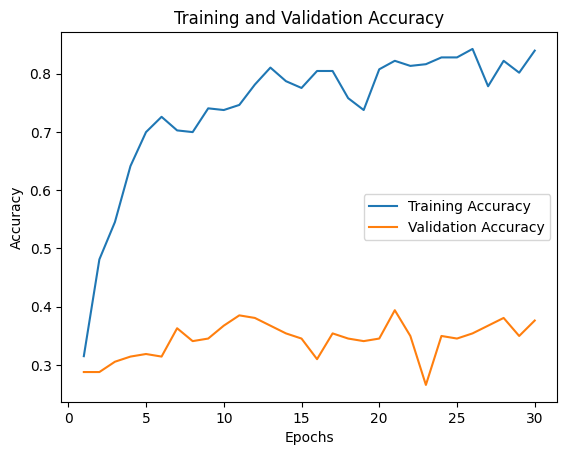

In [108]:
# Get training and validation accuracy from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show plot
plt.show()

# Performance Metrics:

In [109]:
from sklearn.metrics import classification_report

# Get true labels from the validation generator
y_true = validation_generator.classes

# Get predicted probabilities from the model
y_pred_prob = model.predict(validation_generator)

# Convert predicted probabilities to class labels
y_pred = y_pred_prob.argmax(axis=1)

class_names = list(validation_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
              precision    recall  f1-score   support

       angry       0.17      0.15      0.16        33
       happy       0.34      0.40      0.36        68
     relaxed       0.21      0.25      0.23        64
         sad       0.25      0.16      0.20        61

    accuracy                           0.26       226
   macro avg       0.24      0.24      0.24       226
weighted avg       0.25      0.26      0.25       226



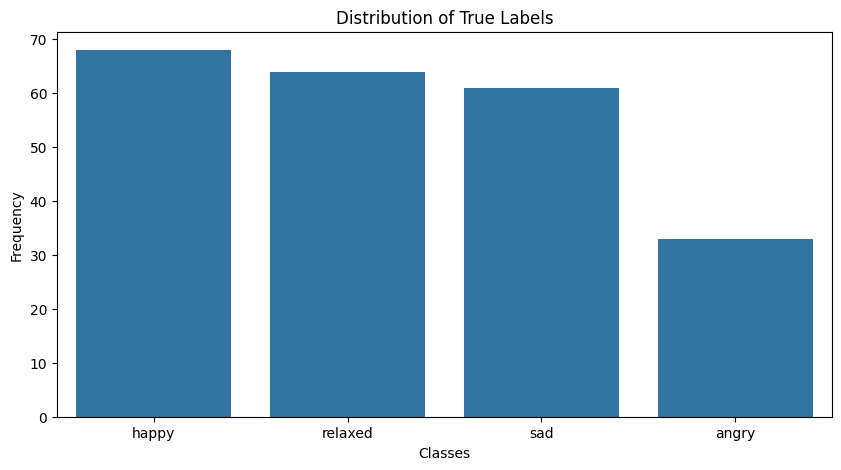

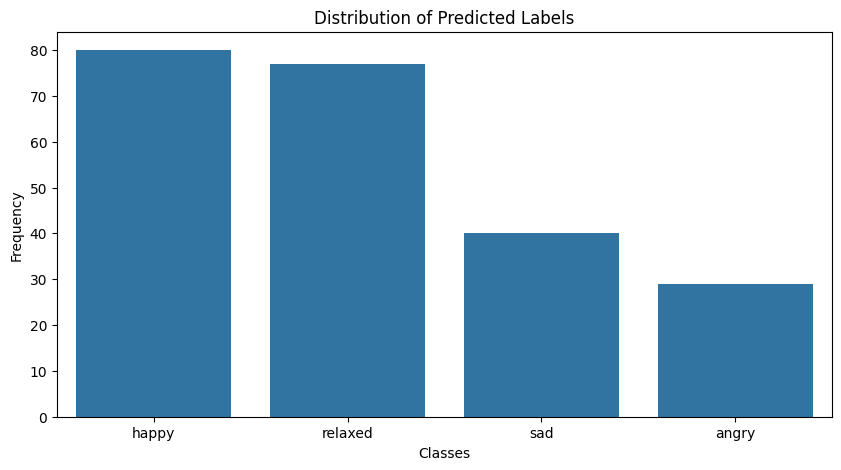

In [110]:
import seaborn as sns
import pandas as pd

# Plot distribution of true labels
true_label_counts = pd.Series(y_true).value_counts()
true_label_counts.index = [class_names[i] for i in true_label_counts.index]

plt.figure(figsize=(10, 5))
sns.barplot(x=true_label_counts.index, y=true_label_counts.values)
plt.title('Distribution of True Labels')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of predicted labels
pred_label_counts = pd.Series(y_pred).value_counts()
pred_label_counts.index = [class_names[i] for i in pred_label_counts.index]

plt.figure(figsize=(10, 5))
sns.barplot(x=pred_label_counts.index, y=pred_label_counts.values)
plt.title('Distribution of Predicted Labels')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()


## ROC/AUC

In [111]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC AUC
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3])
y_pred_binarized = label_binarize(y_pred, classes=[0, 1, 2, 3])

roc_auc = roc_auc_score(y_true_binarized, y_pred_prob, multi_class='ovr')
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.49250207006888425


## Precision, Recall, F-1 Score

In [112]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Precision: 0.25304582509342965
Recall: 0.25663716814159293
F1 Score: 0.2510505401407064


## Confusion Matrix

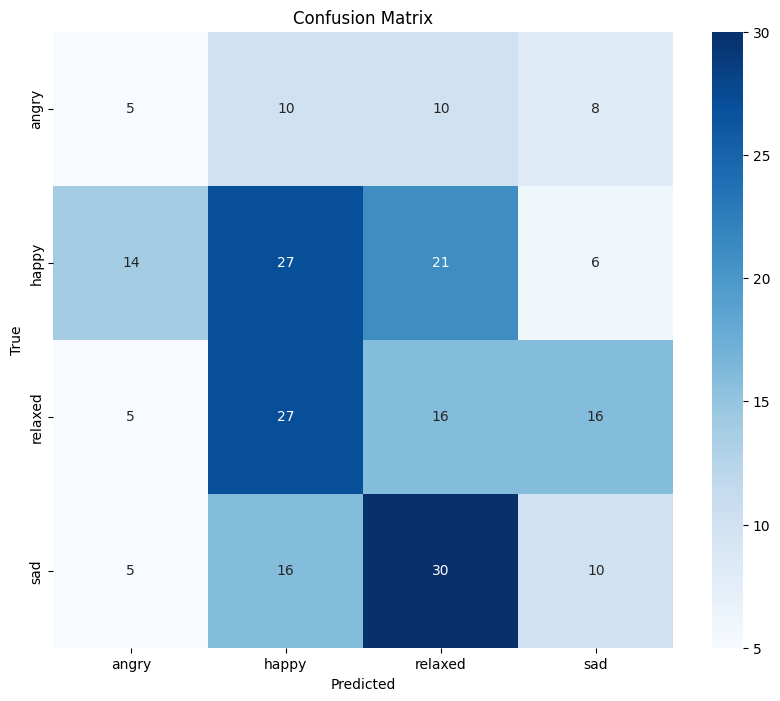

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(validation_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Accuracy

In [114]:
from sklearn.metrics import accuracy_score
# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Overall Accuracy: {accuracy}')

Overall Accuracy: 0.25663716814159293
